#A. Hybrid NCF with quantum-classical layer

##1. Setup

Please run the following code to obtain the dataset from Kaggle and load it in the `sample_data` folder. Install IBM Qiskit to create a quantum circuit

In [ ]:
"""

Mount the Google drive by copying the API key obtained after signing in
Create a hidden folder, kaggle
Copy the API key from the drive into the folder
Change folder permissions
Download the movielens dataset from kaggle and unzip in the sample_data folder

"""

!pip install -q kaggle
from google.colab import drive
drive.mount('/gdrive')
!mkdir ~/.kaggle
!cp /gdrive/MyDrive/Colab\ Notebooks/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download grouplens/movielens-latest-small -p /content/sample_data/ --unzip 
!pip install -q qiskit

Mounted at /gdrive
  0% 0.00/971k [00:00<?, ?B/s]
100% 971k/971k [00:00<00:00, 62.5MB/s]
     |████████████████████████████████| 6.1 MB 25.8 MB/s 
     |████████████████████████████████| 18.0 MB 285 kB/s 
     |████████████████████████████████| 235 kB 65.2 MB/s 
     |████████████████████████████████| 207 kB 70.0 MB/s 
     |████████████████████████████████| 2.1 MB 63.2 MB/s 
     |████████████████████████████████| 200 kB 35.7 MB/s 
     |████████████████████████████████| 635 kB 41.9 MB/s 
     |████████████████████████████████| 1.4 MB 57.2 MB/s 
     |████████████████████████████████| 52 kB 1.4 MB/s 
     |████████████████████████████████| 49 kB 6.0 MB/s 
     |████████████████████████████████| 33.9 MB 45 kB/s 
     |████████████████████████████████| 943 kB 36.1 MB/s 
     |████████████████████████████████| 3.2 MB 56.9 MB/s 
     |████████████████████████████████| 6.3 MB 52.2 MB/s 


##2. Import libraries

In [ ]:
import numpy as np
import pandas as pd


import qiskit

import torch as T
from torch.utils.data import Dataset, random_split, DataLoader
import torch.nn as nn
from torch.autograd import Variable

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt


##3. Data Generation

Creates data and target values

In [ ]:
class Movielens_Ratings(Dataset):
  def __init__(self,nrows):
    """

    Generates the Movielens data

    Args:

      nrows: Total number of rows from the datatset
      ratings: DataFrame stores ratings data [userId, movieId, rating, timestamp] and two features [user, movie] are added with sequential values
      movies: DataFrame stores information about the movie [movieId, title, genres]
      u2eu: Dictionary containing userId mapped to a sequential number (userId contain discontinuous values)
      m2em: Dictionary containing movieId mapped to a sequential number (movieId contain discontinuous values)
      em2m: Dictionary containing numbers mapped to movieId
      userCount: Total users
      movieCount: Total movies
      data: Tensor of [user, movie] values
      target: Tensor of rating values

    """
    self.ratings = pd.read_csv('/content/sample_data/ratings.csv',parse_dates=['timestamp'],nrows=nrows)
    self.movies = pd.read_csv('/content/sample_data/movies.csv')

    #extract all users and movies
    userIds = self.ratings["userId"].unique().tolist()
    movieIds = self.ratings["movieId"].unique().tolist()

    #integer encoding
    self.u2eu = {x: i for i, x in enumerate(userIds)}
    self.m2em = {x: i for i, x in enumerate(movieIds)}
    self.em2m = {i: x for i, x in enumerate(movieIds)}

    self.ratings["user"] = self.ratings["userId"].map(self.u2eu)
    self.ratings["movie"] = self.ratings["movieId"].map(self.m2em)

    self.userCount = len(self.u2eu)
    self.movieCount = len(self.m2em)

    #scale the ratings to 0 to 1
    self.ratings['rating'] = MinMaxScaler().fit_transform(np.array(self.ratings['rating']).reshape(-1,1))

    self.data = T.from_numpy(self.ratings[['user','movie']].values)
    self.target = T.from_numpy(self.ratings['rating'].values)

  def __len__(self): return len(self.data)

  def __getitem__(self,idx): return [self.data[idx], self.target[idx]]

##4. Quantum Circuit

The classes defined in this section and section 5 are obtained from [Hybrid quantum-classical Neural Networks with PyTorch and Qiskit](https://qiskit.org/textbook/ch-machine-learning/machine-learning-qiskit-pytorch.html) tutorial on the Qiskit website.

`QCircuit` cretaes a quantum circuit by using the number of qubits, the *aer simulator* and the number of repetitions per circuit. 

For each qubit, the circuit contains a Hadamard gate followed by a Barrier and a RY gate (rotation along Y axis), ending with a measurement circuit that provides results in 0s and 1s.



In [ ]:
class QCircuit:
    
    def __init__(self, nqubits, backend, shots):
      """

      Quantum circuit

      Args:
      
      nqubits: Number of qubits in the circuit
      backend: Simulator on which the quantum circuit can be run
      shots: Number of repetitions per circuit (sampling)
      circuit: A quantum circuit

      """
      #Circuit definition
      self.circuit = qiskit.QuantumCircuit(nqubits)
      
      allQubits = [i for i in range(nqubits)]
      self.theta = qiskit.circuit.Parameter('theta')
      
      self.circuit.h(allQubits)
      self.circuit.barrier()
      self.circuit.ry(self.theta, allQubits)
      
      self.circuit.measure_all()

      print("="*5,"Quantum Circuit","="*5,"\n",self.circuit)

      #parameter definition
      self.backend = backend #simulator or real quantum computer
      self.shots = shots
    
    def run(self, thetas):
        transpiledQC = qiskit.transpile(self.circuit, self.backend)
        Qobj = qiskit.assemble(transpiledQC, shots=self.shots,parameter_binds = [{self.theta: theta} for theta in thetas])
        job = self.backend.run(Qobj)
        result = job.result().get_counts()
        
        counts = np.array(list(result.values()))
        states = np.array(list(result.keys())).astype(float)
        
        # Compute probabilities for each state
        probabilities = counts / self.shots
        # Get state expectation
        zbasis = np.sum(states * probabilities)
        
        return np.array([zbasis])

##5. Quantum-Classical Functions

The HybridFunction class defines the forward and backward pass of the Backpropagation Algorithm. 

---

In the forward pass function, the output of the quantum cirucit is calculated using the z-basis state. The input and the output is saved for backward pass using `save_for_backward()`.

---

In the backward pass function, tensor containing gradient loss for the output is obtained and the backward pass has to calculate the gradient loss for each input. Since the quantum circuit are unitary computation, the [parmeter-shift rule](https://arxiv.org/pdf/1905.13311.pdf) is applied to evaluate the gradients based on their parameters.

In [ ]:
class HybridFunction(T.autograd.Function):
    """ 
    
    Hybrid quantum - classical function definition 
    
    Args:

    ctx: a buffer between the forward and backward pass
    input: tensor input
    shift: shift angle in terms of radians π/2
    expectation_z: output of quantum circuit according to classical computation in terms of z-basis
    
    """
    
    @staticmethod
    def forward(ctx, input, quantum_circuit, shift):
        """ 
        
        Forward pass         

        """
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit

        expectation_z = []
        for i in range(len(input)):
          expectation_z.append(ctx.quantum_circuit.run(input[i].tolist())) #collect all the ouput of the z-basis into a list  
          
        result = T.tensor(expectation_z)
        ctx.save_for_backward(input, result)

        return result
        
    @staticmethod
    def backward(ctx, gradientOutput):
        """ 
        
        Backward pass  

        Args:

        gradient: gradient loss for each input unit
        
        """
        input, expectation_z = ctx.saved_tensors
        input_list = np.array(input.tolist())
        
        #Parameter-shift rule
        shift_right = input_list + np.ones(input_list.shape) * ctx.shift
        shift_left = input_list - np.ones(input_list.shape) * ctx.shift
        
        gradients = []
        for i in range(len(input_list)):
          expectation_right = ctx.quantum_circuit.run(shift_right[i])
          expectation_left  = ctx.quantum_circuit.run(shift_left[i])
            
          gradient = T.tensor([expectation_right]) - T.tensor([expectation_left])
          gradients.append(gradient)
        
        gradients = np.array([gradients]).T

        return T.tensor([gradients]).float() * gradientOutput.float(), None, None

The Hybrid class is used for invoking the quantum-classical function from a classical machine.


In [ ]:
class Hybrid(nn.Module):
    """ 
    
    Hybrid quantum - classical layer definition 
    
    Args:

    shift: shift angle for parameter-shift rule

    """
    
    def __init__(self, backend, shots, shift):
        super(Hybrid, self).__init__()
        self.quantum_circuit = QCircuit(1, backend, shots)
        self.shift = shift
        
    def forward(self, input):
        return HybridFunction.apply(input, self.quantum_circuit, self.shift)

##6. Recommendation Neural Network

The `RNet` class defines the collaborative filtering network which contains embeddings, bias, sigmoid function and the layer that contains quantum computer. The dot product of user embedding and movie embedding, which is then added to the bias. The resulting tensor sum is passed to the quantum computer for computation and the returned product is passed to a sigmoid fucntion.

In [ ]:
class RNet(nn.Module):
  """
  A collaborative filtering network for recommendation generation

  Args:

  userCount: Total number of users
  movieCount: Total number of movies
  embedding_size: Embedding size for projection
  userEmbedding: Embedding space for users according to the embedding_size
  userBias: User bias
  movieEmbedding: Embedding space for movies according to the embedding_size
  movieBias: Movie Bias
  sigmoid: Activation function
  hybrid: An optimization layer using quantum circuit

  """
  def __init__(self, userCount, movieCount, embedding_size):
      super(RNet,self).__init__()
  
      #embed users and movies and calculate their respective biases
      self.userEmbedding = nn.Embedding(userCount, embedding_dim=embedding_size)
      self.userBias = nn.Embedding(userCount, 1)

      self.movieEmbedding = nn.Embedding(movieCount, embedding_dim=embedding_size)
      self.movieBias = nn.Embedding(movieCount, 1)

      self.sigmoid = nn.Sigmoid() #activation function

      self.hybrid = Hybrid(qiskit.Aer.get_backend('aer_simulator'),100, np.pi/2) #quantum layer
        
  def forward(self,data):

      userVector = self.userEmbedding(data[:,0])
      userBias = self.userBias(data[:,0])

      movieVector = self.movieEmbedding(data[:,1])
      movieBias = self.movieBias(data[:,1])

      dot_UserMovie = T.tensordot(userVector, movieVector) #matrix factorisation

      # Add all the components
      from functools import reduce
      tensorSum = reduce(T.add, [dot_UserMovie,userBias,movieBias])

      x = self.hybrid(tensorSum)

      # The sigmoid activation forces the rating to be between 0 and 1
      return self.sigmoid(x)

##7. Training

* Create an object of the `MovieLens` class and pass the number of rows i.e. 5000 for this notebook.
* The test-size is 30% of the dataset
* The `lengths` contain the train and validation dataset respectively.
* `random_split()` splits the ml dataset into train and validation set.
* `DataLoader` object have been created for the training and validation.

In [ ]:
ml = Movielens_Ratings(5000) #pass the number of rows to be returned

test_size = int(0.3 * len(ml))
lengths = [len(ml)-test_size,test_size] #[train set, validation set]

train, test = random_split(ml,lengths) #train-validation split

trainLoader = DataLoader(train, batch_size=32, shuffle=True) #dataloader for training
testLoader = DataLoader(test, batch_size=64, shuffle=True) #dataloader for validation

The embeddding size is set to 50. An object for `RNet` class is created by passing the total number of users, movies and the embedding size. Adam optimizer is used along with BCE loss.

---

After considering the loss of training and validation set, the number of epochs was set to 3. The model is training and validated while capturing the loss from each round of epoch. 

Before starting the training and validation for each data, the gradients are cleared so that the results of the current step are not affected by the previous step. The prediction is flattened to a single dimension so that they could be evaluated for loss with the target dataset. 

In [ ]:
def modelExecution(dLoader):
  tLoss,rmse = [], []
  for batchid, (data,target) in enumerate(dLoader):
    optimizer.zero_grad() #clear gradients
    pred = model(data) #computing the output of the model
    loss = criterion(T.flatten(pred),target) #calculating the loss
    rmseLoss = T.sqrt(mse(T.flatten(pred),target))
    loss.backward() #assigning credit
    optimizer.step() #model weights update
    tLoss.append(loss.item())
    rmse.append(rmseLoss.item())
  return tLoss, rmse

In [46]:
embeddingSize = 50

model = RNet(ml.userCount,ml.movieCount,embeddingSize)

optimizer = T.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()
mse = nn.MSELoss()

epochs = range(3)
train_loss, test_loss, trainRMSE, testRMSE = [],[], [], []

for epoch in epochs:
  #================== Training ===========================
  model.train() #training mode
  trainLoss, rmseLoss = modelExecution(trainLoader)
  train_loss.append(sum(trainLoss)/len(trainLoss))
  trainRMSE.append(sum(rmseLoss)/len(rmseLoss))

  #================= Validation =========================
  model.eval() #validation mode
  testLoss, rmseLoss = modelExecution(testLoader)
  test_loss.append(sum(testLoss)/len(testLoss))
  testRMSE.append(sum(rmseLoss)/len(rmseLoss))
  
  print("Epoch %d:\n\tTraining -> BCE:%.4f RMSE:%.4f\n\tValidation-> BCE: %.4f RMSE:%.4f"%(
      epoch,train_loss[-1],trainRMSE[-1],test_loss[-1],testRMSE[-1]))

===== Quantum Circuit ===== 
         ┌───┐ ░ ┌───────────┐ ░ ┌─┐
   q_0: ┤ H ├─░─┤ Ry(theta) ├─░─┤M├
        └───┘ ░ └───────────┘ ░ └╥┘
meas: 1/═════════════════════════╩═
                                 0 
Epoch 0:
	Training -> BCE:0.6684 RMSE:0.2514
	Validation-> BCE: 0.6649 RMSE:0.2577
Epoch 1:
	Training -> BCE:0.6681 RMSE:0.2514
	Validation-> BCE: 0.6654 RMSE:0.2543
Epoch 2:
	Training -> BCE:0.6706 RMSE:0.2527
	Validation-> BCE: 0.6668 RMSE:0.2586


###7.1 Plot

####BCE Loss

A line plot is plotted for training and validation loss against the total number of epochs.


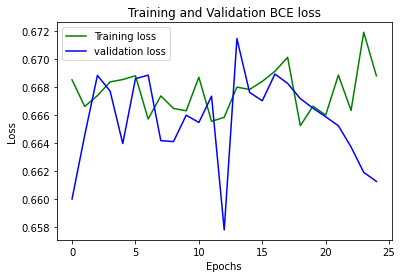

In [44]:
plt.plot(epochs, train_loss, 'g', label='Training loss')
plt.plot(epochs, test_loss, 'b', label='validation loss')
plt.title('Training and Validation BCE loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

####RMSE Loss

A line plot is plotted for training and validation loss against the total number of epochs.

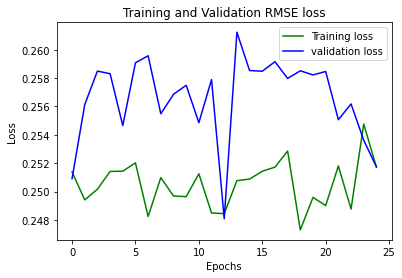

In [45]:
plt.plot(epochs, trainRMSE, 'g', label='Training loss')
plt.plot(epochs, testRMSE, 'b', label='validation loss')
plt.title('Training and Validation RMSE loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

##8. Prediction

* Generate a random userId
* Get the movies watched by the user
* Obtain the list of movies not watched by the user
* Get the encoded value of the user
* Create a user x movie matrix using the userId and movies not watched by the user
* Predict the movies 
* Obtain the top 10 indices of the model output
* Get the movieId of the indices
* Get the name of the movie using the movieId
* Print the name of the movies

In [ ]:
ratings = ml.ratings
movies = ml.movies

#generate random user
randUserId = ratings.userId.sample().iloc[0]

#get the movies watched by the user
watched = ratings[ratings.userId == randUserId]

print("-"*45)
print("Top 5 movie watched by userId =", randUserId)
print("-"*45)
topWatched = (watched.sort_values(by='rating',ascending=False).head(5).movieId.values)
watchedMovies = movies[movies['movieId'].isin(topWatched)] #get the movie names for the movieId
for movie in watchedMovies.itertuples():
  print(movie.title,"\t",movie.genres)

#get the list of movies not watched by the user
notWatched = movies[~movies['movieId'].isin(watched.movieId.values)]['movieId']
notWatched = list(set(notWatched).intersection(set(ml.m2em.keys())))
notWatched = [ml.m2em.get(x) for x in notWatched]

#obtain the encoded value of the user 
encodedUser = ml.u2eu.get(randUserId)

#create a (user,movie) for the user and for each movie not watched by the user
userXmovie = T.tensor(np.stack(([encodedUser]*len(notWatched),notWatched),axis=-1))

ratings = model(userXmovie).flatten()

---------------------------------------------
Top 5 movie watched by userId = 19
---------------------------------------------
Nightmare Before Christmas, The (1993) 	 Animation|Children|Fantasy|Musical
Rear Window (1954) 	 Mystery|Thriller
Maltese Falcon, The (1941) 	 Film-Noir|Mystery
Princess Bride, The (1987) 	 Action|Adventure|Comedy|Fantasy|Romance
Ferris Bueller's Day Off (1986) 	 Comedy


In [ ]:
#get the indices of the top 10 movie
topRatings = ratings.detach().numpy().argsort()[-10:][::-1]

#obtain movieId for these movies
recommendation_movieId = [ml.em2m.get(notWatched[x]) for x in topRatings]

print("-"*45)
print("Top 10 movie recommendation for userId =", randUserId)
print("-"*45)
movieRecommendation = movies[movies['movieId'].isin(recommendation_movieId)]
for movie in movieRecommendation.itertuples():
  print(movie.title,"\t",movie.genres)

---------------------------------------------
Top 10 movie recommendation for userId = 19
---------------------------------------------
Usual Suspects, The (1995) 	 Crime|Mystery|Thriller
Hangar 18 (1980) 	 Action|Sci-Fi|Thriller
Body of Evidence (1993) 	 Drama|Thriller
Lammbock (2001) 	 Comedy
Surviving Christmas (2004) 	 Comedy
Old Boy (2003) 	 Mystery|Thriller
American Pie Presents The Naked Mile (American Pie 5: The Naked Mile) (2006) 	 Comedy|Romance
No Reservations (2007) 	 Comedy|Drama|Romance
Harry Potter and the Deathly Hallows: Part 2 (2011) 	 Action|Adventure|Drama|Fantasy|Mystery|IMAX
American Hustle (2013) 	 Crime|Drama


#B. NCF

##1. Recommendation Neural Network

The class is the vanilla version of the above model without the hybrid class i.e the quantum layer.

In [87]:
class RNetV(nn.Module):
  """
  A collaborative filtering network for recommendation generation

  Args:

  userCount: Total number of users
  movieCount: Total number of movies
  embedding_size: Embedding size for projection
  userEmbedding: Embedding space for users according to the embedding_size
  userBias: User bias
  movieEmbedding: Embedding space for movies according to the embedding_size
  movieBias: Movie Bias
  sigmoid: Activation function
  hybrid: An optimization layer using quantum circuit

  """
  def __init__(self, userCount, movieCount, embedding_size):
      super(RNetV,self).__init__()
  
      #embed users and movies and calculate their respective biases
      self.userEmbedding = nn.Embedding(userCount, embedding_dim=embedding_size)
      self.userBias = nn.Embedding(userCount, 1)

      self.movieEmbedding = nn.Embedding(movieCount, embedding_dim=embedding_size)
      self.movieBias = nn.Embedding(movieCount, 1)

      self.sigmoid = nn.Sigmoid() #activation function
      self.double()
        
  def forward(self,data):

      userVector = self.userEmbedding(data[:,0])
      userBias = self.userBias(data[:,0])

      movieVector = self.movieEmbedding(data[:,1])
      movieBias = self.movieBias(data[:,1])

      dot_UserMovie = T.tensordot(userVector, movieVector) #matrix factorisation

      # Add all the components
      from functools import reduce
      tensorSum = reduce(T.add, [dot_UserMovie,userBias,movieBias])

      # The sigmoid activation forces the rating to be between 0 and 1
      return self.sigmoid(tensorSum)

##2. Training and Validation

In [88]:
def modelExecutionV(dLoader):
  tLoss,rmse = [], []
  for batchid, (data,target) in enumerate(dLoader):
    optimizer.zero_grad() #clear gradients
    pred = modelv(data) #computing the output of the model
    loss = criterion(T.flatten(pred),target) #calculating the loss
    rmseLoss = T.sqrt(mse(pred,target))
    loss.backward() #assigning credit
    optimizer.step() #model weights update
    tLoss.append(loss.item())
    rmse.append(rmseLoss.item())
  return tLoss, rmse

In [89]:
modelv = RNetV(ml.userCount,ml.movieCount,embeddingSize)

epochs = range(3)
train_loss, test_loss, trainRMSE, testRMSE = [],[], [], []


for epoch in epochs:
  #================== Training ===========================
  modelv.train() #training mode
  trainLoss, rmseLoss = modelExecutionV(trainLoader)
  train_loss.append(sum(trainLoss)/len(trainLoss))
  trainRMSE.append(sum(rmseLoss)/len(rmseLoss))

  #================= Validation =========================
  modelv.eval() #validation mode
  testLoss, rmseLoss = modelExecution(testLoader)
  test_loss.append(sum(testLoss)/len(testLoss))
  testRMSE.append(sum(rmseLoss)/len(rmseLoss))
  
  print("Epoch %d:\n\tTraining -> BCE:%.4f RMSE:%.4f\n\tValidation-> BCE: %.4f RMSE:%.4f"%(
      epoch,train_loss[-1],trainRMSE[-1],test_loss[-1],testRMSE[-1]))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([12])) that is different to the input size (torch.Size([12, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, ta

Epoch 0:
	Training -> BCE:18.5321 RMSE:0.5557
	Validation-> BCE: 27.5130 RMSE:0.5583
Epoch 1:
	Training -> BCE:20.2075 RMSE:0.5333
	Validation-> BCE: 21.2670 RMSE:0.5829
Epoch 2:
	Training -> BCE:20.9860 RMSE:0.5517
	Validation-> BCE: 23.7537 RMSE:0.5513


###Plot

Plot BCE and RMSE for training and test set

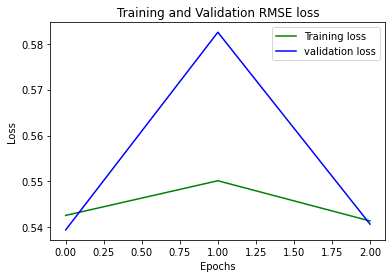

In [86]:
plt.plot(epochs, trainRMSE, 'g', label='Training loss')
plt.plot(epochs, testRMSE, 'b', label='validation loss')
plt.title('Training and Validation RMSE loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

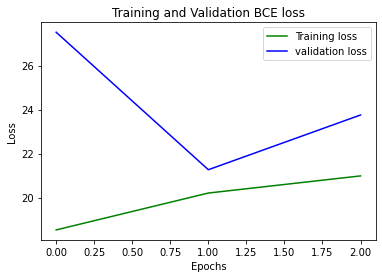

In [91]:
plt.plot(epochs, train_loss, 'g', label='Training loss')
plt.plot(epochs, test_loss, 'b', label='validation loss')
plt.title('Training and Validation BCE loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()